In [82]:
import pandas as pd
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\singh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\singh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [81]:
# Load CSV dataset
df = pd.read_csv("C:/Users/singh/OneDrive/Desktop/Vaish/Reviews.csv")

# Quick look at data
display(df.head())
display(df.info())
display(df.isnull().sum())

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


None

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [64]:
# Convert Unix timestamp to datetime
df['Date'] = pd.to_datetime(df['Time'], unit='s')

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day


In [65]:
# Handle null values
df['Summary'] = df['Summary'].fillna('')
df['ProfileName'] = df['ProfileName'].fillna('')

# Combine into one column
df['review'] = df['Summary'] + " " + df['Text']

display(df.head(5))


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Date,Year,Month,Day,review
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27,2011,4,27,Good Quality Dog Food I have bought several of...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,2012,9,7,Not as Advertised Product arrived labeled as J...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18,2008,8,18,"""Delight"" says it all This is a confection tha..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,2011-06-13,2011,6,13,Cough Medicine If you are looking for the secr...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,2012-10-21,2012,10,21,Great taffy Great taffy at a great price. The...


In [66]:
#Preprocessing Text
#Raw Review:
#"This product is AMAZING!!! I’ve been using it for 2 months & it works better than others."

#After Preprocessing:
#"product amazing month work good"

#Remove stopwords, stopwords are common words (like the, is, was) that add little meaning.
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    
    # Lower case all text so everything is same format
    text = text.lower()

    #remove punctuation , numbers and special charachters
    text = re.sub(r'[^a-z\s]', '', text)   
    words = text.split()

    # Normalize words to their base form like running will become run , better will be good, mice will be mouse
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

df['clean_review'] = df['review'].apply(preprocess_text)


In [67]:
display(df.head(5))

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Date,Year,Month,Day,review,clean_review
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27,2011,4,27,Good Quality Dog Food I have bought several of...,good quality dog food bought several vitality ...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,2012,9,7,Not as Advertised Product arrived labeled as J...,advertised product arrived labeled jumbo salte...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18,2008,8,18,"""Delight"" says it all This is a confection tha...",delight say confection around century light pi...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,2011-06-13,2011,6,13,Cough Medicine If you are looking for the secr...,cough medicine looking secret ingredient robit...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,2012-10-21,2012,10,21,Great taffy Great taffy at a great price. The...,great taffy great taffy great price wide assor...


In [68]:
#Sentiment Analysis based on Score column

def label_sentiment(score):
    if score >= 4:
        return 'Positive'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Negative'

df['sentiment'] = df['Score'].apply(label_sentiment)

display(df.head(5))


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Date,Year,Month,Day,review,clean_review,sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27,2011,4,27,Good Quality Dog Food I have bought several of...,good quality dog food bought several vitality ...,Positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,2012,9,7,Not as Advertised Product arrived labeled as J...,advertised product arrived labeled jumbo salte...,Negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18,2008,8,18,"""Delight"" says it all This is a confection tha...",delight say confection around century light pi...,Positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,2011-06-13,2011,6,13,Cough Medicine If you are looking for the secr...,cough medicine looking secret ingredient robit...,Negative
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,2012-10-21,2012,10,21,Great taffy Great taffy at a great price. The...,great taffy great taffy great price wide assor...,Positive


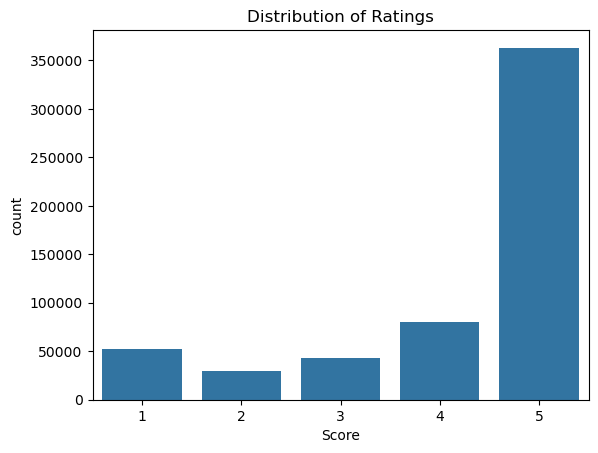

In [69]:
# Exploratory analysis
#Distribution of ratings

sns.countplot(x='Score', data=df)
plt.title("Distribution of Ratings")
plt.show()


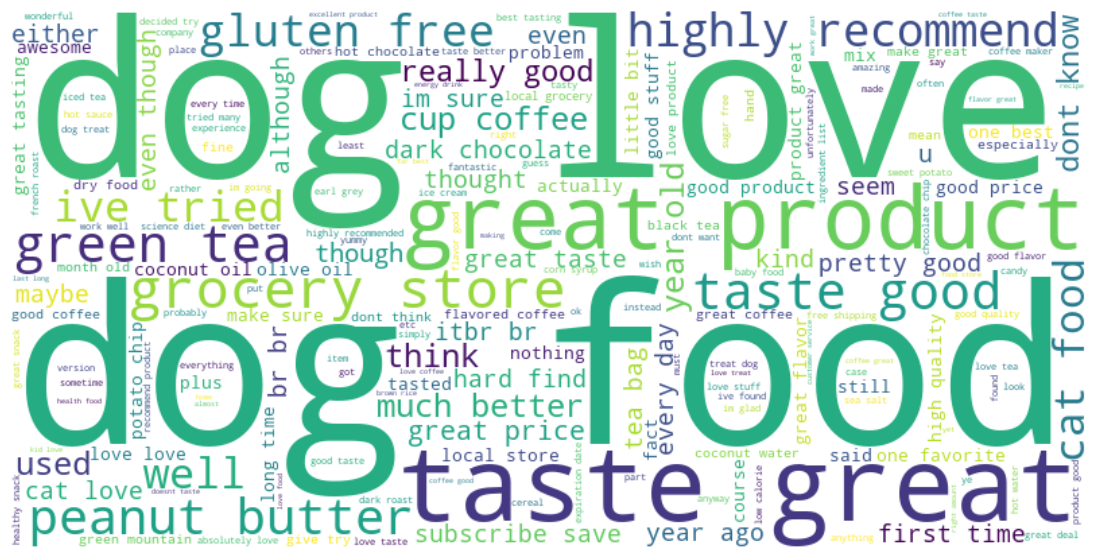

In [70]:
#Word cloud
all_text = " ".join(df['clean_review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


<Axes: title={'center': 'Number of Reviews Per Year'}, xlabel='Year'>

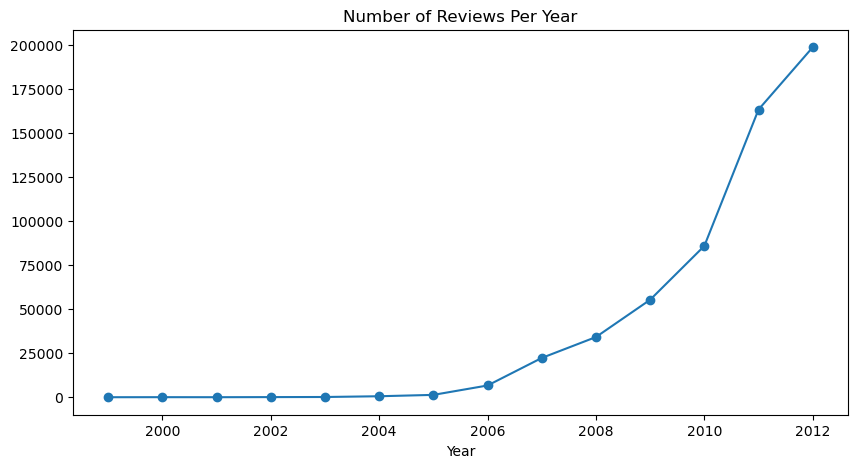

In [71]:
reviews_per_year = df.groupby('Year').size()
reviews_per_year.plot(kind='line', marker='o', figsize=(10,5), title="Number of Reviews Per Year")


<Axes: title={'center': 'Number of Reviews Per Month'}, xlabel='Month'>

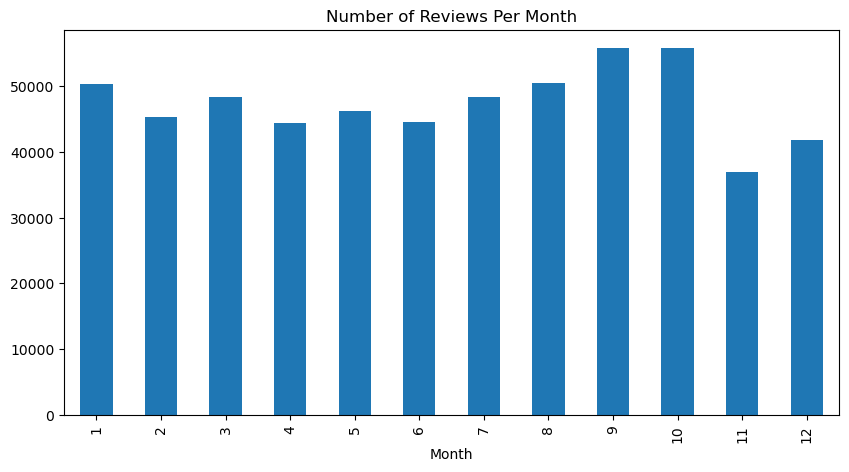

In [72]:
reviews_per_month = df.groupby('Month').size()
reviews_per_month.plot(kind='bar', figsize=(10,5), title="Number of Reviews Per Month")


In [73]:
# sentiment_polarity is added containing a numeric sentiment score for each review.
# TextBlob calculates a polarity score for the text:-1.0 → very negative sentiment , 0 → neutral sentiment, +1.0 → very positive sentiment
df['sentiment_polarity'] = df['clean_review'].apply(lambda x: TextBlob(x).sentiment.polarity)
df[['Score','sentiment_polarity']].head()

,Score,sentiment_polarity
0,5,0.480000
1,1,0.216667
2,4,0.187000
3,2,0.150000
4,5,0.526667


In [74]:
#predict the sentiment of reviews (Positive, Neutral, Negative) based on the text.

#split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(df['clean_review'], df['sentiment'], test_size=0.2, random_state=42)


              precision    recall  f1-score   support

    Negative       0.85      0.34      0.48     16181
     Neutral       0.61      0.01      0.02      8485
    Positive       0.83      1.00      0.90     89025

    accuracy                           0.83    113691
   macro avg       0.76      0.45      0.47    113691
weighted avg       0.81      0.83      0.78    113691



In [75]:
#convert text to number using TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000)

#learns the vocabulary from training data and converts it to numeric vectors
X_train_vect = vectorizer.fit_transform(X_train)

#converts test data into the same vector space
X_test_vect = vectorizer.transform(X_test)



In [76]:
#For text classification Multinominal Naive Bayes is common model 
#Naive Bayes : The model calculates the probability of a class (Positive, Neutral, Negative) given the features (words in the review) and predicts the class with the highest probability.
#Gaussian NB → works for continuous features
#Bernoulli NB → works for binary features (word present/absent)
#Multinomial NB → works for count or frequency features (word counts or TF-IDF)

#Multinomial NB Works well for amazon because amazon reviews are text-heavy and high-dimensional

model = MultinomialNB()
model.fit(X_train_vect, y_train)

MultinomialNB()

In [77]:
#Make predictions

y_pred = model.predict(X_test_vect)

In [83]:
#Evaluate the model 
#Precision → proportion of predicted positives that are correct
#Recall → proportion of actual positives detected correctly
#F1-score → balance between precision and recall
#Accuracy → overall correct predictions

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.85      0.34      0.48     16181
     Neutral       0.61      0.01      0.02      8485
    Positive       0.83      1.00      0.90     89025

    accuracy                           0.83    113691
   macro avg       0.76      0.45      0.47    113691
weighted avg       0.81      0.83      0.78    113691



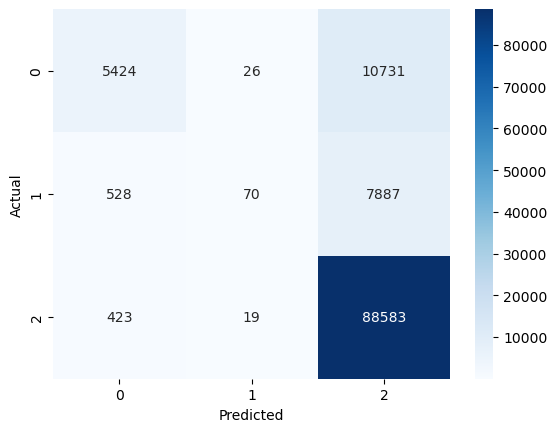

In [84]:
#visualise confusion matrix 
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [86]:
new_reviews = [
    "I love this product, it works perfectly!",
    "It's okay, not too bad but not great either.",
    "Completely useless, very disappointed."
]

new_reviews_vect = vectorizer.transform(new_reviews)
predictions = model.predict(new_reviews_vect)

for review, pred in zip(new_reviews, predictions):
    print(f"Review: {review}\nPredicted Sentiment: {pred}\n")


Review: I love this product, it works perfectly!
Predicted Sentiment: Positive

Review: It's okay, not too bad but not great either.
Predicted Sentiment: Positive

Review: Completely useless, very disappointed.
Predicted Sentiment: Negative

